## Importations

In [3]:
import pandas as pd
import numpy as np
import sqlalchemy as sql
import configparser
import datetime
import matplotlib.pyplot as plt 
from matplotlib.colors import ListedColormap
import seaborn as sns
from sklearn import metrics
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer


Bad key "text.kerning_factor" on line 4 in
/home/ubuntu/anaconda3/envs/analytics/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


## Configuration

In [4]:
config = configparser.ConfigParser()
config.read('../config/default.ini')

['../config/default.ini']

In [5]:
engine = sql.create_engine('postgresql://{}:{}@{}:{}/{}'.format(config['DATABASE']['username'], config['DATABASE']['password'].replace('_percentage_', '%'), config['DATABASE']['host'], config['DATABASE']['port'], config['DATABASE']['database']))

## Utilitaires

In [6]:
bottom_date = '2019-07-01'

In [7]:
palette = {
    'article': '#2276ef',
    'video': '#f4806e',
    'audio': '#f48000',
    'live': '#00946e',
}

In [8]:
def export_df(df, name):
    df.to_csv('output/{}_{}.csv'.format(datetime.datetime.strftime(datetime.datetime.now(), '%y%m%d'), name), index=False, encoding='utf-8-sig')

In [9]:
def read_df(name):
    return pd.read_csv('output/{}_{}.csv'.format(datetime.datetime.strftime(datetime.datetime.now(), '%y%m%d'), name), encoding='utf-8-sig')

In [10]:
def assign_segment(score):
    if score == '222':
        return 'Core'
    elif score[1:2] == '2':
        return 'Loyal'
    elif score[1:2] == '2':
        return 'Loyal'
    elif score[2:] == '2':
        return 'Whales'
    elif score[:2] == '20':
        return 'Rookies'
    elif score[:2] == '00':
        return 'Sleeping'
    else:
        return 'Regular'    

In [11]:
def order_cluster(cluster_field_name, target_field_name, df, ascending):
    new_cluster_field_name = 'new_'+cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name, ascending = ascending).reset_index(drop=True)
    df_new['index']=df_new.index
    df_final = pd.merge(df, df_new[[cluster_field_name, 'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name], axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

In [12]:
def set_value(row_number, assigned_value): 
    return assigned_value[row_number] 

## Données

### Articles

In [10]:
df_article = pd.read_sql_query("""SELECT conso.uid, conso.date, COUNT(DISTINCT conso.article_id) AS conso FROM egos_conso_article_connected_user conso WHERE date > '{}' GROUP BY uid, date""".format(bottom_date), engine)
df_article.head()

uid       date  conso
0                   3c4a77d87f434f839766830140a9bcc0 2020-05-25      7
1                   e0a5c9a5e065467b8a2e8fe439f690f8 2020-03-27      1
2  _guid_YRZolZ574KTRf01xH_VERbNRKggDgWK7Qzdy4W_N... 2020-02-12      1
3  _guid_zLzQ_F08O-1dvqL_F8TUHxkfFq8r2AcbVk-T1CeM... 2020-04-12      1
4                   216f5877ea5147148a17ddc53fabfa83 2020-01-14      4

In [11]:
df_article.count()

uid      11135471
date     11135471
conso    11135471
dtype: int64

In [12]:
df_article.shape

(11135471, 3)

In [13]:
df_article.isnull().any()

uid      False
date     False
conso    False
dtype: bool

---

In [14]:
today = datetime.datetime.now()
df_recency_ar = df_article[['uid', 'date']].groupby('uid').max().reset_index()
df_recency_ar['recency'] = df_recency_ar['date'].apply(lambda x: (today - x).days)
df_recency_ar = df_recency_ar[['uid', 'recency']]
df_recency_ar.head()

uid  recency
0  0000178f7271412ba791e5498feebd65       54
1  0000b3d0bb034d04af4fcd0fbf7ca762       92
2  0000ba0c9608433a88093f1c8cee60f6      223
3  0000f6ae2c2245dc902a4b409b3ef6fc      137
4  00010e2cf80f42208f2b77495e9a70fb       44

In [15]:
df_frequency_ar = df_article[['uid', 'date']].groupby('uid').count().reset_index().rename(columns={'date': 'frequency'})
df_frequency_ar.head()

uid  frequency
0  0000178f7271412ba791e5498feebd65         44
1  0000b3d0bb034d04af4fcd0fbf7ca762          5
2  0000ba0c9608433a88093f1c8cee60f6          2
3  0000f6ae2c2245dc902a4b409b3ef6fc          1
4  00010e2cf80f42208f2b77495e9a70fb         19

In [16]:
df_volume_ar = df_article[['uid', 'conso']].groupby('uid').sum().reset_index().rename(columns={'conso': 'volume'})
df_volume_ar.head()

uid  volume
0  0000178f7271412ba791e5498feebd65      69
1  0000b3d0bb034d04af4fcd0fbf7ca762      10
2  0000ba0c9608433a88093f1c8cee60f6       3
3  0000f6ae2c2245dc902a4b409b3ef6fc       1
4  00010e2cf80f42208f2b77495e9a70fb      26

In [17]:
df_rfv_art = df_recency_ar.merge(df_frequency_ar, on='uid', how='inner')
df_rfv_art = df_rfv_art.merge(df_volume_ar, on='uid', how='inner')
df_rfv_art.head()

uid  recency  frequency  volume
0  0000178f7271412ba791e5498feebd65       54         44      69
1  0000b3d0bb034d04af4fcd0fbf7ca762       92          5      10
2  0000ba0c9608433a88093f1c8cee60f6      223          2       3
3  0000f6ae2c2245dc902a4b409b3ef6fc      137          1       1
4  00010e2cf80f42208f2b77495e9a70fb       44         19      26

In [18]:
#_ = sns.pairplot(df_rfv_art, kind='reg', diag_kind='kde')

In [ ]:
export_df(df_rfv_art, 'rfv_articles')

---
### Vidéos

In [19]:
df_video = pd.read_sql_query("""SELECT conso.uid, conso.date, COUNT(DISTINCT conso.media_id) AS conso FROM egos_conso_audio_video_connected_user conso WHERE conso.media_type = 'video' AND date > '{}' GROUP BY uid, date""".format(bottom_date), engine)
df_video.head()

uid        date  conso
0  _guid_-2HxvrB57T6Rzcpo8QbUcpR0Blm4ifEuiqiJAUqj...  2019-07-28      3
1                   49b3589cc9be4aaea0cc2099dc0969fa  2020-05-28     28
2                   5ede502fcadc4193ac54bf780b35f006  2019-12-23      5
3  _guid_x-hW8InU3HVOZ3ILa-mkuOT2DD-IJnAeb6si2EUC...  2020-06-16     13
4                   0c31ecf1c01b4d4498dac5440e00f93a  2020-07-23      5

In [20]:
df_video.count()

uid      22298588
date     22298588
conso    22298588
dtype: int64

In [21]:
df_video.shape

(22298588, 3)

In [22]:
df_video.isnull().any()

uid      False
date     False
conso    False
dtype: bool

---

In [23]:
today = datetime.datetime.now().date()
df_recency_vi = df_video[['uid', 'date']].groupby('uid').max().reset_index()
df_recency_vi['recency'] = df_recency_vi['date'].apply(lambda x: (today - x).days)
df_recency_vi = df_recency_vi[['uid', 'recency']]
df_recency_vi.head()

uid  recency
0  00005491a39443238ebc3fff842fb175       15
1  00008c78a2f446c3bc43fd0c7beef560      280
2  0000b3d0bb034d04af4fcd0fbf7ca762        2
3  0000ba0c9608433a88093f1c8cee60f6      223
4  0000c9c89046403aaa2552860bb304a7      359

In [24]:
df_frequency_vi = df_video[['uid', 'date']].groupby('uid').count().reset_index().rename(columns={'date': 'frequency'})
df_frequency_vi.head()

uid  frequency
0  00005491a39443238ebc3fff842fb175          1
1  00008c78a2f446c3bc43fd0c7beef560          1
2  0000b3d0bb034d04af4fcd0fbf7ca762        130
3  0000ba0c9608433a88093f1c8cee60f6          1
4  0000c9c89046403aaa2552860bb304a7          1

In [25]:
df_volume_vi = df_video[['uid', 'conso']].groupby('uid').sum().reset_index().rename(columns={'conso': 'volume'})
df_volume_vi.head()

uid  volume
0  00005491a39443238ebc3fff842fb175       1
1  00008c78a2f446c3bc43fd0c7beef560       2
2  0000b3d0bb034d04af4fcd0fbf7ca762     176
3  0000ba0c9608433a88093f1c8cee60f6       1
4  0000c9c89046403aaa2552860bb304a7       1

In [26]:
df_rfv_vid = df_recency_vi.merge(df_frequency_vi, on='uid', how='inner')
df_rfv_vid = df_rfv_vid.merge(df_volume_vi, on='uid', how='inner')
df_rfv_vid.head()

uid  recency  frequency  volume
0  00005491a39443238ebc3fff842fb175       15          1       1
1  00008c78a2f446c3bc43fd0c7beef560      280          1       2
2  0000b3d0bb034d04af4fcd0fbf7ca762        2        130     176
3  0000ba0c9608433a88093f1c8cee60f6      223          1       1
4  0000c9c89046403aaa2552860bb304a7      359          1       1

In [ ]:
#_ = sns.pairplot(df_rfv_vid, kind='reg', diag_kind='kde')

In [ ]:
export_df(df_rfv_vid, 'rfv_videos')

---
### Audios

In [27]:
df_audio = pd.read_sql_query("""SELECT conso.uid, conso.date, COUNT(DISTINCT conso.media_id) AS conso FROM egos_conso_audio_video_connected_user conso WHERE conso.media_type = 'audio' AND date > '{}' GROUP BY uid, date""".format(bottom_date), engine)
df_audio.head()

uid        date  conso
0  0005e3d950014919bdb6b40d22467f5a  2020-01-11      1
1  0010bf7ba1554cbd83912f4096881887  2020-07-14      2
2  0017bb58a99944afb090d87bd1943d2f  2019-09-05      1
3  002944d3c6334c03ac583fa48ab4a4d4  2020-01-29      3
4  003b521e308541a5826573411410e214  2020-03-21      1

In [28]:
df_audio.count()

uid      756161
date     756161
conso    756161
dtype: int64

In [29]:
df_audio.shape

(756161, 3)

In [30]:
df_audio.isnull().any()

uid      False
date     False
conso    False
dtype: bool

---

In [31]:
today = datetime.datetime.now().date()
df_recency_au = df_audio[['uid', 'date']].groupby('uid').max().reset_index()
df_recency_au['recency'] = df_recency_au['date'].apply(lambda x: (today - x).days)
df_recency_au = df_recency_au[['uid', 'recency']]
df_recency_au.head()

uid  recency
0  00011c8566a44fbb92e5f63f7c3e365a      212
1  000217c622694ec58b10ca253198c890      186
2  000249394c6f406893d18649b5425673      412
3  00026ccfb3164f7f831f6b87e53410ac       72
4  00027afa83ee4e14abe71b43b39f9e75      179

In [32]:
df_frequency_au = df_audio[['uid', 'date']].groupby('uid').count().reset_index().rename(columns={'date': 'frequency'})
df_frequency_au.head()

uid  frequency
0  00011c8566a44fbb92e5f63f7c3e365a          3
1  000217c622694ec58b10ca253198c890          3
2  000249394c6f406893d18649b5425673          1
3  00026ccfb3164f7f831f6b87e53410ac          1
4  00027afa83ee4e14abe71b43b39f9e75          2

In [33]:
df_volume_au = df_audio[['uid', 'conso']].groupby('uid').sum().reset_index().rename(columns={'conso': 'volume'})
df_volume_au.head()

uid  volume
0  00011c8566a44fbb92e5f63f7c3e365a       3
1  000217c622694ec58b10ca253198c890       3
2  000249394c6f406893d18649b5425673       2
3  00026ccfb3164f7f831f6b87e53410ac       1
4  00027afa83ee4e14abe71b43b39f9e75       3

In [34]:
df_rfv_au = df_recency_au.merge(df_frequency_au, on='uid', how='inner')
df_rfv_au = df_rfv_au.merge(df_volume_au, on='uid', how='inner')
df_rfv_au.head()

uid  recency  frequency  volume
0  00011c8566a44fbb92e5f63f7c3e365a      212          3       3
1  000217c622694ec58b10ca253198c890      186          3       3
2  000249394c6f406893d18649b5425673      412          1       2
3  00026ccfb3164f7f831f6b87e53410ac       72          1       1
4  00027afa83ee4e14abe71b43b39f9e75      179          2       3

In [ ]:
#_ = sns.pairplot(df_rfv_au, kind='reg', diag_kind='kde')

In [ ]:
export_df(df_rfv_au, 'rfv_audios')

---
### Live

In [35]:
df_live = pd.read_sql_query("""SELECT conso.uid, conso.date, COUNT(DISTINCT conso.media_id) AS conso FROM egos_conso_audio_video_connected_user conso WHERE conso.media_type = 'live' AND date > '{}' GROUP BY uid, date""".format(bottom_date), engine)
df_live.head()

uid        date  conso
0  00010e2cf80f42208f2b77495e9a70fb  2020-04-24      1
1  000249394c6f406893d18649b5425673  2020-04-29      3
2  000249394c6f406893d18649b5425673  2020-07-07      2
3  0005b650df1f4042befb0b1a392c3197  2020-04-04      1
4  0005e8881a5549eabf1a9d6dd0f3a324  2020-02-12      1

In [36]:
df_live.count()

uid      8331926
date     8331926
conso    8331926
dtype: int64

In [37]:
df_live.shape

(8331926, 3)

In [38]:
df_live.isnull().any()

uid      False
date     False
conso    False
dtype: bool

---

In [39]:
today = datetime.datetime.now().date()
df_recency_li = df_live[['uid', 'date']].groupby('uid').max().reset_index()
df_recency_li['recency'] = df_recency_li['date'].apply(lambda x: (today - x).days)
df_recency_li = df_recency_li[['uid', 'recency']]
df_recency_li.head()

uid  recency
0  0000178f7271412ba791e5498feebd65      164
1  00005491a39443238ebc3fff842fb175       15
2  00008c78a2f446c3bc43fd0c7beef560      280
3  0000b3d0bb034d04af4fcd0fbf7ca762       58
4  0000ba0c9608433a88093f1c8cee60f6      252

In [40]:
df_frequency_li = df_live[['uid', 'date']].groupby('uid').count().reset_index().rename(columns={'date': 'frequency'})
df_frequency_li.head()

uid  frequency
0  0000178f7271412ba791e5498feebd65          1
1  00005491a39443238ebc3fff842fb175          1
2  00008c78a2f446c3bc43fd0c7beef560          1
3  0000b3d0bb034d04af4fcd0fbf7ca762          8
4  0000ba0c9608433a88093f1c8cee60f6          1

In [41]:
df_volume_li = df_live[['uid', 'conso']].groupby('uid').sum().reset_index().rename(columns={'conso': 'volume'})
df_volume_li.head()

uid  volume
0  0000178f7271412ba791e5498feebd65       1
1  00005491a39443238ebc3fff842fb175       1
2  00008c78a2f446c3bc43fd0c7beef560       1
3  0000b3d0bb034d04af4fcd0fbf7ca762       8
4  0000ba0c9608433a88093f1c8cee60f6       1

In [42]:
df_rfv_li = df_recency_li.merge(df_frequency_li, on='uid', how='inner')
df_rfv_li = df_rfv_li.merge(df_volume_li, on='uid', how='inner')
df_rfv_li.head()

uid  recency  frequency  volume
0  0000178f7271412ba791e5498feebd65      164          1       1
1  00005491a39443238ebc3fff842fb175       15          1       1
2  00008c78a2f446c3bc43fd0c7beef560      280          1       1
3  0000b3d0bb034d04af4fcd0fbf7ca762       58          8       8
4  0000ba0c9608433a88093f1c8cee60f6      252          1       1

In [ ]:
#_ = sns.pairplot(df_rfv_li, kind='reg', diag_kind='kde')

In [ ]:
export_df(df_rfv_li, 'rfv_lives')

---
## Jointure

In [5]:
df_rfv_art = pd.read_csv('output/200817_rfv_articles.csv')
df_rfv_vid = pd.read_csv('output/200817_rfv_videos.csv')
df_rfv_au = pd.read_csv('output/200817_rfv_audios.csv')
df_rfv_li = pd.read_csv('output/200817_rfv_lives.csv')

In [44]:
df_rfv_art.shape

(819014, 4)

In [45]:
df_rfv_vid.shape

(1517578, 4)

In [46]:
df_rfv_au.shape

(266893, 4)

In [47]:
df_rfv_li.shape

(941358, 4)

In [8]:
df_rfv_art['type'] = 'article'
df_rfv_vid['type'] = 'video'
df_rfv_au['type'] = 'audio'
df_rfv_li['type'] = 'live'
df_rfv = pd.concat([df_rfv_art, df_rfv_vid, df_rfv_au, df_rfv_li],ignore_index=True)
df_rfv.shape

(3510413, 5)

In [19]:
df_rfv = read_df('rfv')

In [18]:
export_df(df_rfv, 'rfv')

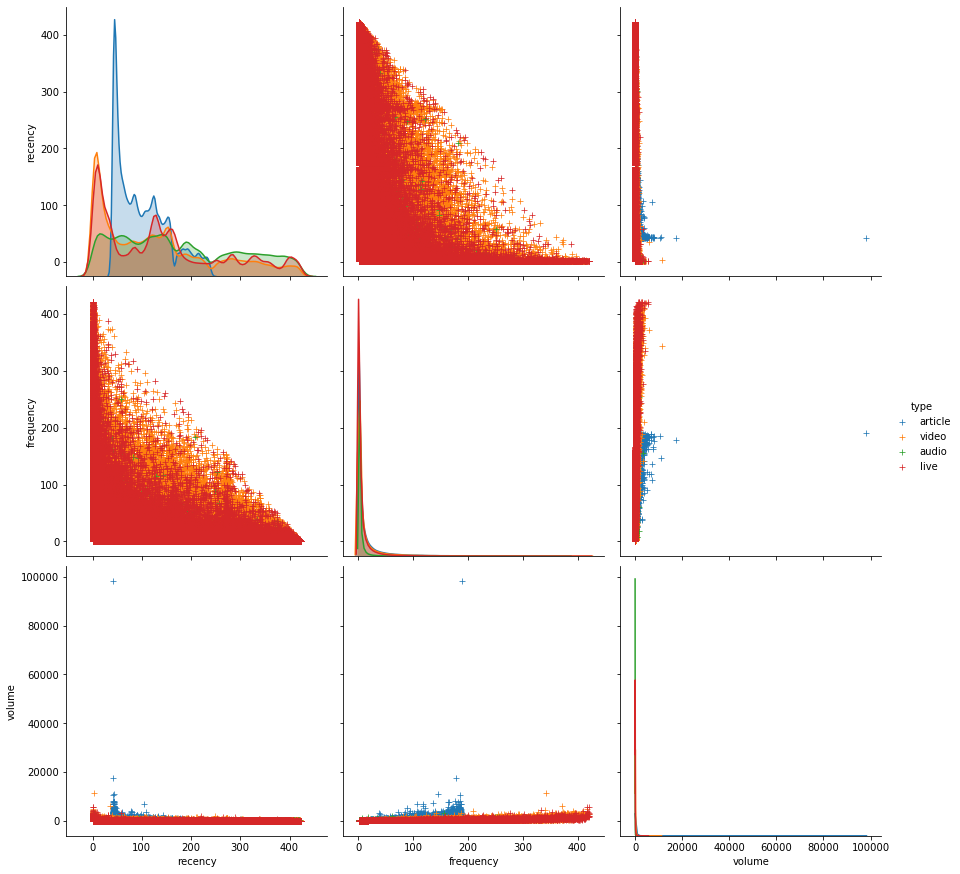

In [49]:
_ = sns.pairplot(df_rfv, kind='scatter', diag_kind='kde', hue='type', height=4, markers='+')

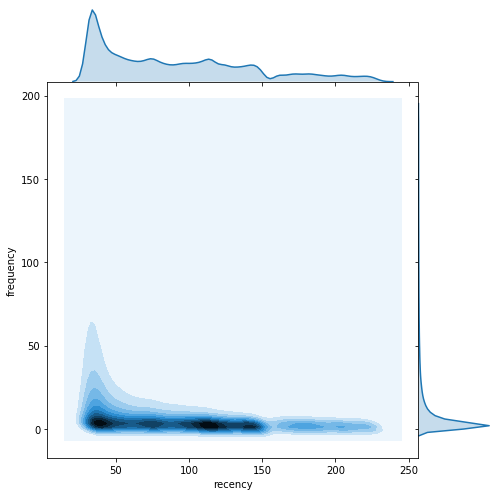

In [20]:
df = df_rfv[df_rfv['type'] == 'article']
sns.jointplot(df['recency'], df['frequency'], kind='kde', height=7, space=0)

In [ ]:
df = df_rfv[df_rfv['type'] == 'video']
sns.jointplot(df['recency'], df['frequency'], kind='kde', height=7, space=0)

In [ ]:
df = df_rfv[df_rfv['type'] == 'audio']
sns.jointplot(df['recency'], df['frequency'], kind='kde', height=7, space=0)

In [ ]:
df = df_rfv[df_rfv['type'] == 'live']
sns.jointplot(df['recency'], df['frequency'], kind='kde', height=7, space=0)

## Normalisation des variables

In [ ]:
ord_columns = ['recency', 'frequency', 'volume']
cat_columns = ['first_type', 'most_type', 'last_type']

In [ ]:
df_rfv.describe()

In [ ]:
df_rfv_norm = df_rfv.copy()
for col in ord_columns:
    df_rfv_norm[col] = preprocessing.PowerTransformer().fit_transform(df_rfv_norm[[col]])
df_rfv_norm.describe()

In [ ]:
_ = sns.pairplot(df_rfv_norm, kind='scatter', diag_kind='kde', hue='type', height=4, markers='+')

In [ ]:
df = df_rfv_norm[df_rfv_norm['type'] == 'article']
sns.jointplot(df['recency'], df['frequency'], kind='kde', height=7, space=0)

In [ ]:
df = df_rfv_norm[df_rfv_norm['type'] == 'video']
sns.jointplot(df['recency'], df['frequency'], kind='kde', height=7, space=0)

In [ ]:
df = df_rfv_norm[df_rfv_norm['type'] == 'audio']
sns.jointplot(df['recency'], df['frequency'], kind='kde', height=7, space=0)

In [ ]:
df = df_rfv_norm[df_rfv_norm['type'] == 'live']
sns.jointplot(df['recency'], df['frequency'], kind='kde', height=7, space=0)

## Analyse RFV pour tous les utilisateurs

In [ ]:
df_article['type'] = 'article'
df_video['type'] = 'video'
df_audio['type'] = 'audio'
df_live['type'] = 'live'
df_conso = pd.concat([df_article, df_video, df_audio, df_live], ignore_index=True)
df_conso.count()

In [ ]:
types = df_conso['type'].unique()
types

### RFV 

In [ ]:
today = datetime.datetime.now().date()
df_recency = df_conso[['uid', 'date']].groupby('uid').max().reset_index()
df_recency['recency'] = df_recency['date'].apply(lambda x: (today - (x if type(x) == datetime.date else x.date())).days)
df_recency = df_recency[['uid', 'recency']]
df_recency.head()

In [ ]:
df_frequency = df_conso[['uid', 'date']].groupby('uid').count().reset_index().rename(columns={'date': 'frequency'})
df_frequency.head()

In [ ]:
df_volume = df_conso[['uid', 'conso']].groupby('uid').sum().reset_index().rename(columns={'conso': 'volume'})
df_volume.head()

In [ ]:
df_rfv_uid = df_recency.merge(df_frequency, on='uid', how='inner')
df_rfv_uid = df_rfv_uid.merge(df_volume, on='uid', how='inner')
df_rfv_uid.head()

In [ ]:
#df_rfv_uid = pd.read_csv('output/200819_rfv_per_uid.csv')

In [ ]:
export_df(df_rfv_uid, 'rfv_per_uid')

---

### Clustering

In [ ]:
df_ord_date = df_conso[['uid', 'date', 'type']].sort_values(by=['uid', 'date'])
df_first = df_ord_date.drop_duplicates(subset='uid', keep='first')
df_last = df_ord_date.drop_duplicates(subset='uid', keep='last')

In [ ]:
df_rfv_uid = df_rfv_uid.merge(df_first[['uid', 'type']], on='uid', suffixes=['','']).rename(columns={'type': 'first_type'})
df_rfv_uid = df_rfv_uid.merge(df_last[['uid', 'type']], on='uid', suffixes=['','']).rename(columns={'type': 'last_type'})
df_rfv_uid.head()

In [ ]:
df_most = df_conso[['uid', 'type']].groupby(by=['uid', 'type']).size().reset_index()
df_most = df_most[['uid', 'type', 0]].sort_values(by=['uid', 0])
df_most = df_most.drop_duplicates(subset='uid', keep='last')
df_most.head()

In [ ]:
df_rfv_uid = df_rfv_uid.merge(df_most[['uid', 'type']], on='uid', suffixes=['','']).rename(columns={'type': 'most_type'})
df_rfv_uid.head(20)

In [ ]:
df_rfv_uid.shape[0] - df_rfv_uid['uid'].unique().shape[0]

In [ ]:
df_rfv_uid.shape

In [ ]:
export_df(df_rfv_uid, 'rfv_per_uid')

---

### Cluster pour chaque indicateur R / F / V

In [ ]:
_ = sns.pairplot(df_rfv_uid, kind='scatter', diag_kind='kde', height=4, markers='+')

In [ ]:
recency_cleaned = df_rfv_uid[df_rfv_uid['recency']<df_rfv_uid['recency'].quantile(0.99)]
frequency_cleaned = df_rfv_uid[df_rfv_uid['frequency']<df_rfv_uid['frequency'].quantile(0.99)]
monetary_cleaned = df_rfv_uid[df_rfv_uid['volume']<df_rfv_uid['volume'].quantile(0.99)]
rfv_table = pd.merge(pd.merge(recency_cleaned,frequency_cleaned[['uid']],on='uid'),monetary_cleaned[['uid']],on='uid')
rfv_table.shape

In [ ]:
_ = sns.pairplot(rfv_table, kind='scatter', diag_kind='kde', height=4, markers='+')

In [ ]:
sse={}
tx_recency = rfv_table[['recency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(tx_recency)
    tx_recency['clusters'] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel('Number of clusters')
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(rfv_table[['recency']])
rfv_table['recencyCluster'] = kmeans.predict(rfv_table[['recency']])
rfv_table = order_cluster('recencyCluster','recency', rfv_table, False)

In [ ]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(rfv_table[['frequency']])
rfv_table['frequencyCluster'] = kmeans.predict(rfv_table[['frequency']])
rfv_table = order_cluster('frequencyCluster','frequency', rfv_table, True)

In [ ]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(rfv_table[['volume']])
rfv_table['volumeCluster'] = kmeans.predict(rfv_table[['volume']])
rfv_table = order_cluster('volumeCluster','volume', rfv_table, True)

In [ ]:
c = rfv_table.groupby('recencyCluster')['recency'].agg(['min','max','mean']).reset_index()
r1 = '<={}'.format(c.iloc[2,2]) 
r2 = '{}-{}'.format(c.iloc[1,1], c.iloc[1,2]) 
r3 = '>='.format(c.iloc[0,1])

R = {0 : r3, 1 : r2, 2 : r1} 
rfv_table['recencyClusterTag'] = rfv_table['recencyCluster'].apply(set_value, args=(R,))

In [ ]:
a = rfv_table.groupby('frequencyCluster')['frequency'].agg(['min','max','mean']).reset_index()
f1 = '<={}'.format(a.iloc[0,2]) 
f2 = '{}-{}'.format(a.iloc[1,1], a.iloc[1,2]) 
f3 = '>={}'.format(a.iloc[2,1])

F = {0 : f1, 1 : f2, 2 : f3} 
rfv_table['frequencyClusterTag'] = rfv_table['frequencyCluster'].apply(set_value, args=(F,)) 

In [ ]:
b = rfv_table.groupby('volumeCluster')['volume'].agg(['min','max','mean']).reset_index()
v1 = '<={}'.format(int(round(b.iloc[0,2]))) 
v2 = '{}-{}'.format(int(round(b.iloc[0,2])+1), int(round(b.iloc[1,2])))
v3 = '>={}'.format(int(round(b.iloc[1,2])+1))

V = {0 : v1, 1 : v2, 2 : v3} 
rfv_table['volumeClusterTag'] = rfv_table['volumeCluster'].apply(set_value, args=(V,)) 

In [ ]:
rfv_table['frequencyClusterTag'] = rfv_table['frequencyClusterTag'].astype(pd.api.types.CategoricalDtype(categories=[f1, f2, f3]))
rfv_table['volumeClusterTag'] = rfv_table['volumeClusterTag'].astype(pd.api.types.CategoricalDtype(categories=[m1, m2,m3]))
rfv_table['recencyClusterTag'] = rfv_table['recencyClusterTag'].astype(pd.api.types.CategoricalDtype(categories=[r1, r2,r3]))

In [ ]:
rfv_table.head()

In [ ]:
sns.countplot(x='recencyClusterTag', data=rfv_table, color='steelblue')

In [ ]:
sns.countplot(x='frequencyClusterTag', data=rfv_table, color='steelblue')

In [ ]:
sns.countplot(x='volumeClusterTag', data=rfv_table, color='steelblue')

In [ ]:
rfv_table['recencyCluster'] = rfv_table['recencyCluster'].astype(str)
rfv_table['frequencyCluster'] = rfv_table['frequencyCluster'].astype(str)
rfv_table['volumeCluster'] = rfv_table['volumeCluster'].astype(str)
rfv_table['RFV Score'] = rfv_table[['recencyCluster', 'frequencyCluster', 'volumeCluster']].agg(''.join, axis=1)

In [ ]:
rfv_tags = rfv_table.groupby(by='RFV Score').size().reset_index().rename(columns={0: 'users'})
rfv_tags.head()

In [ ]:
rfv_tags['segment'] = rfv_tags['RFV Score'].apply(assign_segment)
rfv_tags.head(20)

In [ ]:
rfv_segments = rfv_tags[['segment', 'users']].groupby('segment').sum().reset_index().rename(columns={'sum':'users'})
rfv_segments.head(20)

In [ ]:
sns.barplot(x='segment', y='users', data=rfv_segments, color='steelblue')

In [ ]:
rfv_table['segment'] = rfv_table['RFV Score'].apply(assign_segment)
rfv_table.head()

In [ ]:
rfv_most = rfv_table.groupby(by=['segment', 'most_type']).size().reset_index().rename(columns={0: 'users'})
rfv_most.head()

In [ ]:
types = rfv_most['most_type'].unique()
rfv_most_type = pd.DataFrame(columns=['segment', *types])
for i, row in rfv_most.iterrows():
    obj = {
        'segment': row['segment'],
        row['most_type']: row['users']
    }
    rfv_most_type = rfv_most_type.append(obj, ignore_index=True)
rfv_most_type = rfv_most_type.groupby('segment').sum().reset_index()
rfv_most_type.head(20)

In [ ]:
rfv_most_type['total'] = np.sum(rfv_most_type[types], axis=1)
rfv_most_type.head()

In [ ]:
for val in types:
    rfv_most_type['{}_per'.format(val)] = rfv_most_type[val]/rfv_most_type['total']
rfv_most_type.head()

In [ ]:
sns.set()
order = ['Whales', 'Sleeping', 'Rookies', 'Regular', 'Loyal', 'Core']
rfv_most_type[['segment', *['{}_per'.format(x) for x in types]]].set_index('segment').loc[order].plot(kind='barh', stacked=True, colormap=ListedColormap(sns.color_palette('Set2')), figsize=(15,10))
plt.ylabel('Segment', fontsize = 20)

---

### Cluster avec tous les variables

In [ ]:
_ = sns.pairplot(df_rfv_uid, kind='scatter', diag_kind='kde', hue='most_type', height=4, markers='+', palette=palette)

In [ ]:
_ = sns.pairplot(df_rfv_uid, kind='scatter', diag_kind='kde', hue='first_type', height=4, markers='+', palette=palette)

In [ ]:
_ = sns.pairplot(df_rfv_uid, kind='scatter', diag_kind='kde', hue='last_type', height=4, markers='+', palette=palette)

In [ ]:
sns.jointplot(df_rfv_uid['recency'], df_rfv_uid['frequency'], height=10, kind='kde', space=0)

In [ ]:
plt.figure(figsize = (10,10))
sns.violinplot(x='first_type', y='recency', data=df_rfv_uid, order=palette.keys(), inner='quartile', palette=palette)
plt.xlabel('First type', fontsize = 20)
plt.ylabel('Recency', fontsize = 20)
#plt.savefig()
plt.show()

In [ ]:
plt.figure(figsize = (10,10))
sns.violinplot(x='most_type', y='recency', data=df_rfv_uid, order=palette.keys(), inner='quartile', palette=palette)
plt.xlabel('Most common type', fontsize = 20)
plt.ylabel('Recency', fontsize = 20)
#plt.savefig()
plt.show()

In [ ]:
plt.figure(figsize = (10,10))
sns.violinplot(x='last_type', y='recency', data=df_rfv_uid, order=palette.keys(), inner='quartile', palette=palette)
plt.xlabel('Last type', fontsize = 20)
plt.ylabel('Recency', fontsize = 20)
#plt.savefig()
plt.show()

In [ ]:
ord_transformer = preprocessing.PowerTransformer()
cat_transformer = preprocessing.OneHotEncoder()
transformer = ColumnTransformer(
    [('ord', ord_transformer, ord_columns),
     ('cat', cat_transformer, cat_columns)]
)

In [ ]:
df_rfv_clustering = df_rfv_uid.copy()
df_rfv_clustering = df_rfv_clustering[df_rfv_clustering['recency'] < df_rfv_clustering['recency'].quantile(0.99)]
df_rfv_clustering = df_rfv_clustering[df_rfv_clustering['frequency'] < df_rfv_clustering['frequency'].quantile(0.99)]
df_rfv_clustering = df_rfv_clustering[df_rfv_clustering['volume'] < df_rfv_clustering['volume'].quantile(0.99)]

In [ ]:
data = transformer.fit_transform(df_rfv_clustering[[*ord_columns, *cat_columns]])

In [ ]:
pd.DataFrame(data).head(20)

In [ ]:
sse={}
tx_clustering = df_rfv_clustering.copy()
for k in range(1, 20):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(data)
    tx_clustering['clusters'] = kmeans.labels_
    sse[k] = kmeans.inertia_
plt.figure(figsize=(7,5))
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel('Number of clusters')
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=8)
kmeans.fit(data)
df_rfv_clustering['cluster'] = kmeans.predict(data)

In [ ]:
_ = sns.pairplot(df_rfv_clustering, kind='scatter', diag_kind='kde', hue='cluster', height=4, markers='+', palette=sns.color_palette('Set2'))

In [ ]:
pca = PCA(n_components=2)
pca_values = pca.fit_transform(data)
pca_values

In [ ]:
sse={}
tx_clustering = df_rfv_clustering.copy()
for k in range(1, 20):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(pca_values)
    tx_clustering['clusters'] = kmeans.labels_
    sse[k] = kmeans.inertia_
plt.figure(figsize=(7,5))
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel('Number of clusters')
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=8)
kmeans.fit(pca_values)
df_rfv_clustering['cluster_pca'] = kmeans.predict(pca_values)

In [ ]:
list(sse.keys()), list(sse.values())

In [ ]:
df_rfv_clustering['pca_1'] = [x[0] for x in pca_values]
df_rfv_clustering['pca_2'] = [x[1] for x in pca_values]
df_rfv_clustering.head()

In [ ]:
plt.figure(figsize = (12,12))
sns.scatterplot(x='pca_1', y='pca_2', data=df_rfv_clustering, hue='cluster', palette=sns.color_palette('Set2'))
plt.show()

In [ ]:
df_rfv_clustering_ord = df_rfv_clustering[ord_columns]
df_rfv_clustering_ord.head()

In [ ]:
sse={}
tx_clustering = df_rfv_clustering_ord.copy()
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(tx_clustering)
    tx_clustering['clusters'] = kmeans.labels_
    sse[k] = kmeans.inertia_
plt.figure(figsize=(7,5))
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel('Number of clusters')
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(data)
df_rfv_clustering_ord['cluster'] = kmeans.predict(data)

In [ ]:
_ = sns.pairplot(df_rfv_clustering_ord, kind='scatter', diag_kind='kde', hue='cluster', height=4, markers='+', palette=sns.color_palette('Set2'))

In [ ]:
pca = PCA(n_components=2)
pca_values = pca.fit_transform(data)
pca_values

In [ ]:
sse={}
tx_clustering = df_rfv_clustering_ord.copy()
for k in range(1, 20):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(pca_values)
    tx_clustering['clusters'] = kmeans.labels_
    sse[k] = kmeans.inertia_
plt.figure(figsize=(7,5))
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel('Number of clusters')
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=8)
kmeans.fit(pca_values)
df_rfv_clustering_ord['cluster_pca'] = kmeans.predict(pca_values)

In [ ]:
list(sse.keys()), list(sse.values())

In [ ]:
df_rfv_clustering_ord['pca_1'] = [x[0] for x in pca_values]
df_rfv_clustering_ord['pca_2'] = [x[1] for x in pca_values]
df_rfv_clustering_ord.head()

In [ ]:
plt.figure(figsize = (12,12))
sns.scatterplot(x='pca_1', y='pca_2', data=df_rfv_clustering_ord, hue='cluster', palette=sns.color_palette('Set2'))
plt.show()

### Using Kmodes

In [ ]:
df_rfv_clustering['cluster_kmodes'].unique()

In [ ]:
kmeans.cluster_centroids_

In [ ]:
kmodes = KModes(n_clusters=4, init='Huang', n_init=1, verbose=0)
df_rfv_clustering['cluster_kmodes'] = kmodes.fit_predict(tx_clustering)

In [ ]:
pca = PCA(n_components=2)
pca_values = pca.fit_transform(tx_clustering[[*ord_columns]])
pca_values

In [ ]:
plt.figure(figsize = (12,12))
sns.scatterplot(x=pca_values[:,1], y=pca_values[:,0], data=df_rfv_clustering, hue='cluster_kmodes', palette=sns.color_palette('Set2', 4))
plt.show()

In [ ]:
_ = sns.pairplot(df_rfv_clustering[['cluster_kmodes',*ord_columns]], kind='scatter', diag_kind='kde', hue='cluster_kmodes', height=4, markers='+', palette=sns.color_palette('Set2'))

---
# TEMP

In [ ]:
tmp = pd.read_sql_query("""SELECT conso.uid, CAST(conso.article_id AS VARCHAR) AS media_id, 'article' as type, article.title, article.feed AS group FROM egos_conso_article_connected_user conso INNER JOIN article_article article ON conso.article_id = article.id {}""".format("""WHERE EXTRACT(year FROM date) = EXTRACT(year FROM CURRENT_DATE) AND EXTRACT(week FROM date) = (EXTRACT(week FROM CURRENT_DATE)-1)"""), engine)
tmp.head()

In [87]:
tmp[tmp['table_name'].str.contains('conso')]

table_catalog         table_schema  \
1369          a360               public   
1370          a360               public   
1413          a360               public   
1416          a360               public   
1426          a360               public   
1427          a360               public   
1430          a360               public   
1458          a360  articles_characters   
1459          a360  articles_characters   
1460          a360  articles_characters   
1461          a360  articles_characters   
1462          a360  articles_characters   
1484          a360  articles_characters   

                                             table_name      table_type  \
1369                  egos_conso_article_connected_user      BASE TABLE   
1370                     obs_egos_conso_article_per_day      BASE TABLE   
1413              egos_conso_audio_video_connected_user      BASE TABLE   
1416                                 egos_conso_article      BASE TABLE   
1426                           stage_egos_conso_article      BASE TABLE   
1427                         egos_conso_article_per_day      BASE TABLE   
1430                          egos_conso_all_global_agg      BASE TABLE   
1458              a360_public_egos_conso_all_global_agg  EXTERNAL TABLE   
1459                     a360_public_egos_conso_article  EXTERNAL TABLE   
1460      a360_public_egos_conso_article_connected_user  EXTERNAL TABLE   
1461  a360_public_egos_conso_article_connected_user_...  EXTERNAL TABLE   
1462  a360_public_egos_conso_audio_video_connected_user  EXTERNAL TABLE   
1484                                         daim_conso  EXTERNAL TABLE   

     remarks  
1369    None  
1370    None  
1413    None  
1416    None  
1426    None  
1427    None  
1430    None  
1458    None  
1459    None  
1460    None  
1461    None  
1462    None  
1484    None

In [90]:
tmp1 = pd.read_sql_query("""select * from egos_conso_all_global_agg limit 1""", engine)
tmp1.head()

date    year  month   day  connected_total_video  \
0  2018-12-21  2018.0   12.0  21.0                  38988   

   connected_video_auvio  connected_video_site  connected_live  \
0                      0                 38988               0   

   connected_total_audio  connected_audio_auvio  connected_audio_site  \
0                   1540                      0                  1540   

   connected_article  not_connected_total_video  not_connected_video_auvio  \
0              42392                      23182                          0   

   not_connected_video_site  not_connected_live  not_connected_total_audio  \
0                     23182                   0                        839   

   not_connected_audio_auvio  not_connected_audio_site  not_connected_article  
0                          0                       839                 328736

In [91]:
list(tmp1.columns)

['date',
 'year',
 'month',
 'day',
 'connected_total_video',
 'connected_video_auvio',
 'connected_video_site',
 'connected_live',
 'connected_total_audio',
 'connected_audio_auvio',
 'connected_audio_site',
 'connected_article',
 'not_connected_total_video',
 'not_connected_video_auvio',
 'not_connected_video_site',
 'not_connected_live',
 'not_connected_total_audio',
 'not_connected_audio_auvio',
 'not_connected_audio_site',
 'not_connected_article']

In [22]:
df.head()

uid   age  0-14  15-24  25-39  >35 age_range  \
0  0000092334f74ac2af6bbf8ef2907ee1  33.0   NaN    NaN    1.0  NaN     25-34   
1  00021fbd855b4eccb8457360cb1b54b9  63.0   NaN    NaN    NaN  1.0     55-64   
2  000221b1177d41ecbe8ed95342b6c4ae  21.0   NaN    1.0    NaN  NaN     15-24   
3  0004100d9a0d434b910df5249b66fac4  32.0   NaN    NaN    1.0  NaN     25-34   
4  0005028416fa42c79cb9db358ce9087e  53.0   NaN    NaN    NaN  1.0     45-54   

  gender  
0      m  
1      f  
2      m  
3      m  
4      m

In [19]:
last_week = """WHERE EXTRACT(year FROM date) = EXTRACT(year FROM CURRENT_DATE) AND EXTRACT(week FROM date) = (EXTRACT(week FROM CURRENT_DATE)-1)"""

query = """SELECT * FROM (SELECT conso.uid, CAST(conso.article_id AS VARCHAR) AS media_id, 'article' as type, conso.date, article.title, article.feed AS group FROM egos_conso_article_connected_user conso INNER JOIN article_article article ON conso.article_id = article.id {}) UNION ALL (SELECT conso.uid, CAST(conso.media_id AS VARCHAR), conso.media_type as type, conso.date, media.provider as group, media.labelstat as title FROM egos_conso_audio_video_connected_user conso INNER JOIN (SELECT mo.id, mp.labelstat, mo.provider FROM media_objects mo INNER JOIN media_programs mp ON mo.program_id = mp.id) media ON conso.media_id = media.id {})""".format(last_week, last_week)
df = pd.read_sql_query(query, engine)

# Extra information
gigya_aug = pd.read_csv('output/200911_egos_gigya_augmented.csv')

# Final dataset
df = df.merge(gigya_aug, on='uid', how='left')

#['type', 'title', 'group']
preserve = ['media_id',
            '0-14', '15-24', '25-39', '>35', 'age_range', 'gender']


In [15]:
df.head()

uid media_id     type       date  \
0  f942b01382ab4a7996d11379e88469c7      935  article 2020-09-05   
1  4fcd61bbee964a17afbf121cba87aa11      935  article 2020-09-02   
2  2d98f7ed299c4d308e01bf9b9002f3a2  3371533  article 2020-09-02   
3  5cdfa9e29ca44c659f42631d138ee6eb  4696043  article 2020-09-01   
4  5cdfa9e29ca44c659f42631d138ee6eb  4703283  article 2020-09-01   

                                               title      group   age  0-14  \
0  Découvrez les nouvelles entrées dans la playli...      TIPIK   NaN   NaN   
1  Découvrez les nouvelles entrées dans la playli...      TIPIK   NaN   NaN   
2                      Dacourt: "Bölöni m'a humilié"  RTBFSPORT   NaN   NaN   
3  RTBF Inside "Dans les coulisses du Lip dub des...         TV  24.0   NaN   
4                      En coulisse ! (vidéo inédite)         TV  24.0   NaN   

   15-24  25-39  >35 age_range  
0    NaN    NaN  NaN       NaN  
1    NaN    NaN  NaN       NaN  
2    NaN    NaN  NaN       NaN  
3    1.0    NaN  NaN     15-24  
4    1.0    NaN  NaN     15-24

In [16]:
df.groupby(by=['type', 'public', 'gender']).size().reset_index()

KeyError: 'public'

In [73]:
df.groupby(by=['media_id', 'type', 'title', 'group', '>35']).size().reset_index()

media_id   type      title                 group  >35   0
0      1011453  video  INGESTVOD          Sans chichis  0.0   6
1      1016893  video  INGESTVOD    Jardins et Loisirs  1.0   3
2      1028633  video       CRYO  JT - Sujet par sujet  0.0   4
3      1036423  video       CRYO  JT - Sujet par sujet  0.0   2
4      1037183  video       CRYO  JT - Sujet par sujet  0.0   2
...        ...    ...        ...                   ...  ...  ..
30417   964273  video  INGESTVOD          Sans chichis  0.0   3
30418   965233  video       CRYO  JT - Sujet par sujet  1.0   1
30419   968393  video  INGESTVOD          Sans chichis  1.0  12
30420   974323  video       CRYO      Devoir d Enquête  0.0  23
30421   999413  video  INGESTVOD    Jardins et Loisirs  0.0   1

[30422 rows x 6 columns]

In [74]:
df.groupby(by=['media_id', 'type', 'title', 'group', 'public']).size().reset_index()

media_id   type      title                 group public   0
0      1011453  video  INGESTVOD          Sans chichis  25-39   6
1      1047243  video       CRYO  JT - Sujet par sujet  25-39   3
2      1082713  video       CRYO  JT - Sujet par sujet  25-39   8
3      1121273  video       CRYO  JT - Sujet par sujet  25-39  10
4      1135333  video       CRYO  JT - Sujet par sujet  15-24   2
...        ...    ...        ...                   ...    ...  ..
11042   605701  video  INGESTVOD    Jardins et Loisirs  25-39   1
11043   708812  video  INGESTVOD         Comme un chef  25-39   1
11044   731723  video  INGESTVOD           Studio Foot  25-39  68
11045   955423  video       CRYO  JT - Sujet par sujet  15-24   4
11046   962683  video       CRYO  JT - Sujet par sujet  25-39   1

[11047 rows x 6 columns]

In [75]:
df.groupby(by=['media_id', 'type', 'title', 'group', 'gender']).size().reset_index()

media_id   type      title                 group gender   0
0      1011453  video  INGESTVOD          Sans chichis      m   6
1      1028633  video       CRYO  JT - Sujet par sujet      f   4
2      1036423  video       CRYO  JT - Sujet par sujet      m   2
3      1037183  video       CRYO  JT - Sujet par sujet      f   1
4      1037183  video       CRYO  JT - Sujet par sujet      m   2
...        ...    ...        ...                   ...    ...  ..
28317   965233  video       CRYO  JT - Sujet par sujet      f   1
28318   968393  video  INGESTVOD          Sans chichis      f  12
28319   974323  video       CRYO      Devoir d Enquête      f  17
28320   974323  video       CRYO      Devoir d Enquête      m   6
28321   999413  video  INGESTVOD    Jardins et Loisirs      f   1

[28322 rows x 6 columns]

In [98]:
df.groupby(by=['type', '>35', 'gender']).size().reset_index()

type  >35 gender        0
0   audio  0.0      f    21279
1   audio  0.0      m    42296
2   audio  1.0      f    69349
3   audio  1.0      m    93163
4    live  0.0      f       70
5    live  0.0      m       14
6    live  1.0      f       12
7    live  1.0      m       70
8   video  0.0      f  2823797
9   video  0.0      m  2573551
10  video  1.0      f  2128684
11  video  1.0      m  2594358

In [32]:
df.shape

(890495, 13)

In [39]:
df[df['media_id'] == '1011453']

uid media_id   type       date      title  \
10539  f4fb0161bbfa443f9799d10a34ce121d  1011453  video 2020-08-10  INGESTVOD   

              group   age  0-14  15-24  25-39  >35 age_range gender  
10539  Sans chichis  27.0   NaN    NaN    1.0  NaN     25-34      m

In [43]:
df.columns

Index(['uid', 'media_id', 'type', 'date', 'title', 'group', 'age', '0-14',
       '15-24', '25-39', '>35', 'age_range', 'gender'],
      dtype='object')

In [17]:
publics = ['0-14', '15-24', '25-39']

In [20]:
pd.unique(df[preserve].values.ravel('K'))

array(['935', '3371533', '4696043', ..., '45-54', '5-14', '4-13'],
      dtype=object)

In [21]:
df['public'] = df.apply(lambda x: ''.join([pub for pub in publics if x[pub] == x[pub]]), axis=1)

In [22]:
df[~df['public'].isna()]

uid media_id     type       date  \
0        f942b01382ab4a7996d11379e88469c7      935  article 2020-09-05   
1        4fcd61bbee964a17afbf121cba87aa11      935  article 2020-09-02   
2        2d98f7ed299c4d308e01bf9b9002f3a2  3371533  article 2020-09-02   
3        5cdfa9e29ca44c659f42631d138ee6eb  4696043  article 2020-09-01   
4        5cdfa9e29ca44c659f42631d138ee6eb  4703283  article 2020-09-01   
...                                   ...      ...      ...        ...   
1404910  10313e15965c4be6925918bc03d8137f  2676863    video 2020-09-06   
1404911  0dbce2a45ab742c6a6e8e8c26f5b026e  2676863    video 2020-09-06   
1404912  0c63ad6049b54577af2841fc6fce06f8  2676863    video 2020-09-06   
1404913  0989de2c8e0c407c91fa789b50a6ea90  2676863    video 2020-09-06   
1404914  028a77f5dffe4b1d986ec32c7dd09065  2676863    video 2020-09-06   

                                                     title  \
0        Découvrez les nouvelles entrées dans la playli...   
1        Découvrez les nouvelles entrées dans la playli...   
2                            Dacourt: "Bölöni m'a humilié"   
3        RTBF Inside "Dans les coulisses du Lip dub des...   
4                            En coulisse ! (vidéo inédite)   
...                                                    ...   
1404910                                              AREMA   
1404911                                              AREMA   
1404912                                              AREMA   
1404913                                              AREMA   
1404914                                              AREMA   

                        group   age  0-14  15-24  25-39  >35 age_range public  
0                       TIPIK   NaN   NaN    NaN    NaN  NaN       NaN         
1                       TIPIK   NaN   NaN    NaN    NaN  NaN       NaN         
2                   RTBFSPORT   NaN   NaN    NaN    NaN  NaN       NaN         
3                          TV  24.0   NaN    1.0    NaN  NaN     15-24  15-24  
4                          TV  24.0   NaN    1.0    NaN  NaN     15-24  15-24  
...                       ...   ...   ...    ...    ...  ...       ...    ...  
1404910  JT - Sujet par sujet  53.0   NaN    NaN    NaN  1.0     45-54         
1404911  JT - Sujet par sujet   NaN   NaN    NaN    NaN  NaN       NaN         
1404912  JT - Sujet par sujet   NaN   NaN    NaN    NaN  NaN       NaN         
1404913  JT - Sujet par sujet  73.0   NaN    NaN    NaN  1.0       65+         
1404914  JT - Sujet par sujet  54.0   NaN    NaN    NaN  1.0     45-54         

[1404915 rows x 13 columns]

In [23]:
df['>35'] = df['>35'].apply(lambda x: x if x == x else 0)

In [25]:
export_df(df[['uid', '>35', 'age_range', 'public']], 'egos_gigya_augmented')

In [24]:
export_df(df[['uid', '>35', 'age_range', 'gender', 'public']], 'egos_gigya_augmented')

KeyError: "['gender'] not in index"